### INCLUDED

#### Baseline genes as transactions + GO terms, FP vs Ae
#### Vertically expanded for samples  + GO terms. FP vs Ae    

#### Analysis of common term overrepresentation

In [1]:
import pandas as pd
import thesis_functions as tf
from aerial import model, rule_extraction, rule_quality, discretization
import numpy as np
from mlxtend.frequent_patterns import fpgrowth, association_rules


In [ ]:
# Load expression data
expr_matrix_raw = pd.read_csv('Data/gene_expr_matrix_VLCD_LCD_2timepoints.csv', index_col=0) 
metadata = pd.read_csv('Data/metadata_filtered_2timepoints_VLCD_LCD.csv', index_col=0)
# Rename expr_matrix_raw columns using super_id from metadata
expr_matrix_raw.columns = metadata.loc[expr_matrix_raw.columns, 'super_id'].astype(str).values

# Subset only one treatment
super_ids_VLCD = metadata.loc[metadata['treatment'] == 'very-low-calorie diet', 'super_id']
expr_matrix_raw = expr_matrix_raw.loc[:, expr_matrix_raw.columns.isin(super_ids_VLCD)]
expr_matrix_raw.head()

# significant subset only
sig_genenames = pd.read_csv('Data/sig_genenames_VLCD_LCD.csv')
expr_matrix_raw_sig = expr_matrix_raw.loc[expr_matrix_raw.index.intersection(sig_genenames['x'])]
print(expr_matrix_raw_sig.shape) #250 genes, 50 samples (these include before and after)

# Load the full dataset
GO_term_mat = pd.read_csv('Data/go_term_matrix_VLCD_LCD.csv', index_col=0)
GO_term_mat.shape  #240 genes, 2734 GO-terms, 10 genes didnt have GO terms.

(250, 50)


(240, 2735)

In [4]:
expr_matrix_raw_sig.head()

,1A,1B,2A,2B,3A,3B,4A,4B,5A,5B,...,45B,46A,46B,47A,47B,52A,52B,55A,55B,61A
AACS,6.119484,5.954499,7.091046,6.204872,7.121898,6.431687,6.232337,6.074907,6.344019,6.358287,...,6.000650,6.916260,6.020237,7.183228,6.084343,6.511988,6.458463,6.691672,6.259456,6.996723
AADAC,5.742837,6.159056,5.218273,5.715436,4.773760,5.843851,4.095828,5.581445,5.422022,7.000329,...,6.144937,5.173941,4.819199,5.202143,5.537062,4.052324,5.434206,4.164337,5.446170,6.236813
ABCB11,3.263683,5.455237,3.001000,4.337801,4.846125,5.986115,3.291753,3.282246,5.509475,7.053325,...,4.981686,3.763709,3.637255,4.236047,4.937940,5.899767,6.817970,4.706861,7.076605,7.026304
ABCC6,6.248035,5.131170,5.641004,5.411726,5.767713,4.584088,5.599325,5.172479,4.439270,4.696274,...,5.369631,6.531842,5.602687,5.594228,4.904626,5.870304,5.420647,5.705527,5.300562,5.263231
ABCC6P2,6.358351,5.413584,6.062927,5.488108,6.240490,5.353764,6.527384,6.777927,4.606221,5.329591,...,5.505645,6.650421,6.050458,6.541816,5.500843,6.094665,5.428735,5.975307,5.406738,5.949176


In [5]:
GO_term_mat.head()



,GO:0008191,GO:0071353,GO:0008047,GO:1903077,GO:0044458,GO:0071280,GO:0030492,GO:0033024,GO:0004364,GO:0038166,...,GO:0061436,GO:0045724,GO:0034612,GO:0015734,GO:0032700,GO:0035988,GO:0086013,GO:0016045,GO:0090314,GO:1904645
gene,,,,,,,,,,,,,,,,,,,,,
FADS2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FADS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SCD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NQO1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
import pandas as pd
import re
import numpy as np

def reshape_expression_matrix(expr_matrix_raw, threshold=0.1):
    """
    Reshape an expression matrix from wide format (genes as rows, samples as columns)
    to long format with specific conditions. FOR GENES AS TRANSACTIONS
    
    Parameters:
    -----------
    expr_matrix_raw : pandas.DataFrame
        Input expression matrix with gene names as row indices and sample conditions as columns.
        Column names should be in format like '1A', '1B', where the number indicates the sample
        and the letter indicates the condition (A = before study start, B = after dietary intervention).
    
    Returns:
    --------
    pandas.DataFrame
        Reshaped DataFrame with columns: 'Gene name, Gene_Upregulated, Gene_Downregulated.
        Row indices will be in the format 'gene_sample'.
    """
    # Create an empty list to store the reshaped data
    reshaped_data = []
    
    # Extract all unique sample numbers
    sample_numbers = set()
    for col in expr_matrix_raw.columns:
        # Extract the numeric part from the column name
        match = re.match(r'(\d+)[A-Z]', col)
        if match:
            sample_numbers.add(match.group(1))
    
    # For each gene and sample, extract the values for conditions A and B
    for gene_name in expr_matrix_raw.index:
        for sample in sample_numbers:
            # Check if the specific columns exist
            col_a = f"{sample}A"
            col_b = f"{sample}B"
            
            if col_a in expr_matrix_raw.columns and col_b in expr_matrix_raw.columns:
                before_value = expr_matrix_raw.loc[gene_name, col_a]
                after_value = expr_matrix_raw.loc[gene_name, col_b]
                
                # Add this data to our list
                reshaped_data.append({
                    'gene': gene_name,
                    'before study start': before_value,
                    'after dietary intervention': after_value
                })
    
    # Create a DataFrame from the collected data
    reshaped = pd.DataFrame(reshaped_data)
    
    # Create row indices in the format 'gene_sample'
    # First, we need to track which sample each row corresponds to
    sample_tracking = []
    for gene in expr_matrix_raw.index:
        for sample in sample_numbers:
            col_a = f"{sample}A"
            col_b = f"{sample}B"
            if col_a in expr_matrix_raw.columns and col_b in expr_matrix_raw.columns:
                sample_tracking.append(f"{gene}_{sample}")
    
    # Set the index of the result DataFrame
    reshaped.index = sample_tracking
    reshaped['Change in expr'] = np.log2(reshaped['after dietary intervention']/reshaped['before study start'])
    reshaped['Gene_Upregulated'] = (reshaped['Change in expr'] > threshold).astype(int)
    reshaped['Gene_Downregulated'] = (reshaped['Change in expr'] < -threshold).astype(int)
    reshaped = reshaped.drop(columns=['Change in expr', 'before study start', 'after dietary intervention'])
    reshaped['gene'] = reshaped['gene'].astype(str)

    
    return reshaped



In [7]:
# select 1 sample for baseline
expr_matrix_raw_sig_single = expr_matrix_raw_sig.iloc[:,0:2]
expr_matrix_raw_sig_single.head()
expr_matrix_raw_sig_single_reshaped = reshape_expression_matrix(expr_matrix_raw_sig_single)
print(expr_matrix_raw_sig_single_reshaped.head())

#transaction_df = expr_matrix_raw_sig_single_reshaped.concat(GO_term_mat)
transaction_df_single = pd.merge(expr_matrix_raw_sig_single_reshaped, GO_term_mat, left_on='gene', right_index=True)
transaction_df_single = transaction_df_single.drop(columns='gene')
transaction_df_single.head()


              gene  Gene_Upregulated  Gene_Downregulated
AACS_1        AACS                 0                   0
AADAC_1      AADAC                 1                   0
ABCB11_1    ABCB11                 1                   0
ABCC6_1      ABCC6                 0                   1
ABCC6P2_1  ABCC6P2                 0                   1


,Gene_Upregulated,Gene_Downregulated,GO:0008191,GO:0071353,GO:0008047,GO:1903077,GO:0044458,GO:0071280,GO:0030492,GO:0033024,...,GO:0061436,GO:0045724,GO:0034612,GO:0015734,GO:0032700,GO:0035988,GO:0086013,GO:0016045,GO:0090314,GO:1904645
AACS_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AADAC_1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABCB11_1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABCC6_1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABCD2_1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
metrics_list = ['confidence', 'support', 'zhangs_metric', 'lift']
min_sup = 0.3
min_conf = 0.7

# Perform FP growth with filter and save metrics
itemsets = fpgrowth(transaction_df_single, min_support=min_sup, use_colnames=True, max_len=3)
if itemsets.empty:
    print("No frequent itemsets found with the given min_support.")
    fp_rules = pd.DataFrame()
else:
    fp_rules = association_rules(itemsets, metric="confidence", min_threshold=min_conf, return_metrics= metrics_list)
    # filter rules with target features 
    target_features = {'Gene_Upregulated', 'Gene_Downregulated'}
    fp_rules_filtered = fp_rules[
    fp_rules['consequents'].apply(lambda x: bool(x.intersection(target_features)))]
    print(f'fp rules before filtering for target features: {len(fp_rules)}, after filtering: {len(fp_rules_filtered)}')

print(f"FP rules after filtering: {fp_rules_filtered}")
print(fp_rules_filtered.iloc[:,2:-1].mean())

fp rules before filtering for target features: 11, after filtering: 2
FP rules after filtering:                 antecedents         consequents  confidence   support  \
4              (GO:0005886)  (Gene_Upregulated)    0.745283  0.329167   
7  (GO:0016020, GO:0005886)  (Gene_Upregulated)    0.737374  0.304167   

   zhangs_metric      lift  
4       0.339127  1.233572  
7       0.307491  1.220481  
confidence       0.741328
support          0.316667
zhangs_metric    0.323309
dtype: float64


/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Aerial clearly needs more time for dataframes with a lot of columns

In [ ]:
# Now perform Aerial 
results_Ae, rules_ae = tf.RunPyAerialnTimes(transaction_df_single, ant_sim=min_sup, cons_sim=min_conf, 
                     batch_size=3, n_epochs=3, n=5, save_rules=True, filter_thresholds=True)
rules_ae

number of rules before filtering 1485
number of rules after filtering 2
       Exec Time (s)  Nr Rules  avg Confidence  avg Support  avg Coverage  \
Run 1     321.570877       2.0           0.741         0.32         0.442   

       avg Zhangs Metric  
Run 1              0.323  
number of rules before filtering 15
returning none none
number of rules before filtering 153
number of rules after filtering 2
       Exec Time (s)  Nr Rules  avg Confidence  avg Support  avg Coverage  \
Run 1     321.570877       2.0           0.741         0.32         0.442   
Run 5     331.422086       2.0           0.741         0.32         0.442   

       avg Zhangs Metric  
Run 1              0.323  
Run 5              0.323  


[{'antecedents': ['GO:0005886__1'],
  'consequent': 'Gene_Upregulated__1',
  'support': 0.329,
  'confidence': 0.745,
  'zhangs_metric': 0.339,
  'rule_coverage': 0.442},
 {'antecedents': ['GO:0005886__1', 'GO:0016020__1'],
  'consequent': 'Gene_Upregulated__1',
  'support': 0.304,
  'confidence': 0.737,
  'zhangs_metric': 0.307,
  'rule_coverage': 0.412}]

### Now vertical expansion


In [9]:
# select 1 sample for baseline
expr_matrix_raw_sig 
expr_matrix_raw_sig_reshaped = reshape_expression_matrix(expr_matrix_raw_sig)
print(expr_matrix_raw_sig_reshaped.head())

transaction_df = pd.merge(expr_matrix_raw_sig_reshaped, GO_term_mat, left_on='gene', right_index=True)
transaction_df = transaction_df.drop(columns='gene')
transaction_df.head()

         gene  Gene_Upregulated  Gene_Downregulated
AACS_30  AACS                 0                   0
AACS_1   AACS                 0                   0
AACS_42  AACS                 0                   1
AACS_28  AACS                 0                   1
AACS_47  AACS                 0                   1


,Gene_Upregulated,Gene_Downregulated,GO:0008191,GO:0071353,GO:0008047,GO:1903077,GO:0044458,GO:0071280,GO:0030492,GO:0033024,...,GO:0061436,GO:0045724,GO:0034612,GO:0015734,GO:0032700,GO:0035988,GO:0086013,GO:0016045,GO:0090314,GO:1904645
AACS_30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACS_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACS_42,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACS_28,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACS_47,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
transaction_df.shape
transaction_df.head()


,Gene_Upregulated,Gene_Downregulated,GO:0008191,GO:0071353,GO:0008047,GO:1903077,GO:0044458,GO:0071280,GO:0030492,GO:0033024,...,GO:0061436,GO:0045724,GO:0034612,GO:0015734,GO:0032700,GO:0035988,GO:0086013,GO:0016045,GO:0090314,GO:1904645
AACS_30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACS_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACS_42,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACS_28,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACS_47,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
metrics_list = ['confidence', 'support', 'zhangs_metric', 'lift', 'coverage']
min_sup = 0.015
min_conf = 0.7
# Perform FP growth with filter and save metrics
itemsets = fpgrowth(transaction_df, min_support=min_sup, use_colnames=True, max_len=3)
if itemsets.empty:
    print("No frequent itemsets found with the given min_support.")
    fp_rules = pd.DataFrame()
else:
    fp_rules = association_rules(itemsets, metric="confidence", min_threshold=min_conf, return_metrics= metrics_list)
    # filter rules with target features 
    target_features = {'Gene_Upregulated', 'Gene_Downregulated'}
    fp_rules_filtered = fp_rules[
    fp_rules['consequents'].apply(lambda x: bool(x.intersection(target_features)))]
    print(f'fp rules before filtering for target features: {len(fp_rules)}, after filtering: {len(fp_rules_filtered)}')

print(f"FP rules after filtering: {fp_rules_filtered}")
print(fp_rules_filtered.iloc[:,2:-1].mean())

/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


fp rules before filtering for target features: 4747, after filtering: 5
FP rules after filtering:                   antecedents                       consequents  confidence  \
675              (GO:0006636)              (Gene_Downregulated)        0.75   
690  (GO:0006636, GO:0016020)              (Gene_Downregulated)        0.75   
691              (GO:0006636)  (GO:0016020, Gene_Downregulated)        0.75   
692  (GO:0006636, GO:0006633)              (Gene_Downregulated)        0.75   
694              (GO:0006636)  (GO:0006633, Gene_Downregulated)        0.75   

      support  zhangs_metric       lift  
675  0.015625       0.639716   2.676580  
690  0.015625       0.639716   2.676580  
691  0.015625       0.802128   4.660194  
692  0.015625       0.639716   2.676580  
694  0.015625       0.989362  32.000000  
confidence       0.750000
support          0.015625
zhangs_metric    0.742128
dtype: float64


In [ ]:
# Now perform Aerial 
min_sup = 0.012
min_conf = 0.7
results_ae_full, rules_ae_full = tf.RunPyAerialnTimes(transaction_df, ant_sim=min_sup, cons_sim=min_conf, 
                     batch_size=3, n_epochs=3, n=5, save_rules=True, filter_thresholds=True)
rules_ae_full

# This took way too long

number of rules before filtering 14028
returning none none


libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x12ce73100>
Traceback (most recent call last):
  File "/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/Cellar/python@3.11/3.11.12/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/Cellar/python@3.11/3.11.12/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wai

KeyboardInterrupt: 

In [11]:
transaction_df_narrow = tf.randomly_downsize(transaction_df, row_frac=1, col_frac=0.1)
min_sup = 0.012
min_conf = 0.7
results_ae_full, rules_ae_full = tf.RunPyAerialnTimes(transaction_df_narrow, ant_sim=min_sup, cons_sim=min_conf, 
                     batch_size=3, n_epochs=3, n=5, save_rules=True, filter_thresholds=True)
rules_ae_full

{}

(5760, 50)
115.2

Running Aerial algorithm 5 times...
number of rules before filtering 2946
number of rules after filtering 131
       Exec Time (s)  Nr Rules  avg Confidence  avg Support  avg Coverage  \
Run 1       8.922297     131.0           0.838          0.1         0.995   

       avg Zhangs Metric  
Run 1               0.33  
number of rules before filtering 2880
number of rules after filtering 139
       Exec Time (s)  Nr Rules  avg Confidence  avg Support  avg Coverage  \
Run 1       8.922297     131.0           0.838          0.1         0.995   
Run 2       7.216947     139.0           0.835          0.1         0.995   

       avg Zhangs Metric  
Run 1              0.330  
Run 2              0.345  
number of rules before filtering 3078
number of rules after filtering 137
       Exec Time (s)  Nr Rules  avg Confidence  avg Support  avg Coverage  \
Run 1       8.922297     131.0           0.838          0.1         0.995   
Run 2       7.216947     139.0           0.835  

/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


FP exec_time: 2.7519588470458984

Generating plots...


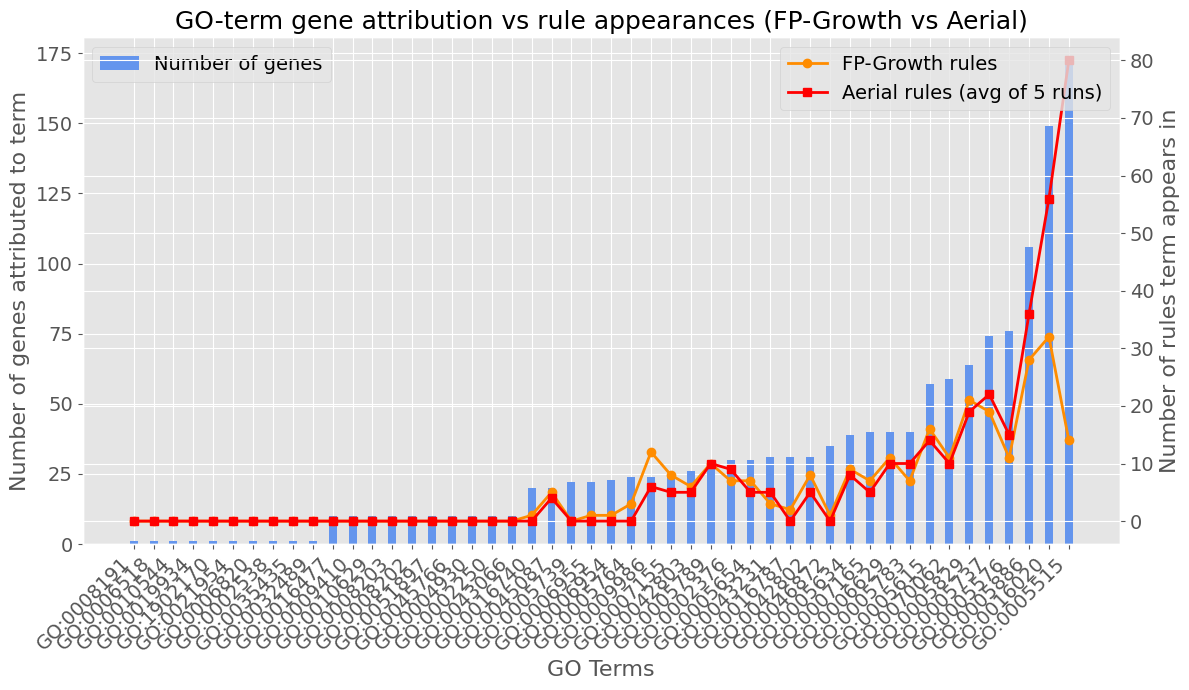

In [1]:
import thesis_functions as tf
import pandas as pd
# Load data (this is the vertical dataframe in which genes appear multiple times)
transaction_df= pd.read_csv('Data/reshaped_gomatrix_selectedterms.csv', index_col=0)
df_numeric = transaction_df.drop(columns='gene name')
print(df_numeric.shape)
# because we have each gene as many times as there is samples in this gene as transaction design
print(df_numeric.shape[0]/df_numeric.shape[1])

# These are the selection of go terms with increasing attributions to genes
selected_terms = pd.read_csv('Data/selected_GOterms.csv', index_col=0)
selected_terms = selected_terms.index.to_list()

results = tf.analyze_go_terms_rules(transaction_df_aerial=df_numeric, transaction_df_fp=df_numeric, selected_terms=selected_terms, 
                        min_support=0.05, min_confidence=0.7,
                        aerial_runs=5, row_expansion=24, filter_thresholds=True)

In [ ]:
results_fp = results['fp_rules']
results_aer = results['aerial_results']
term_counts= results['term_counts']

metrics_to_average = ['support', 'confidence', 'zhangs_metric']
results_aer_df = pd.DataFrame(results_aer)
print(results_aer_df[metrics_to_average].mean())
print(results_fp.iloc[:,2:-1].mean)
print(term_counts)

support          0.100519
confidence       0.833356
zhangs_metric    0.327800
dtype: float64
<bound method DataFrame.mean of      antecedent support  consequent support   support  confidence      lift  \
0              0.308333            0.716667  0.241667    0.783784  1.093652   
1              0.095833            0.716667  0.070833    0.739130  1.031345   
2              0.095833            0.620833  0.079167    0.826087  1.330610   
3              0.103646            0.716667  0.081424    0.785595  1.096179   
4              0.137500            0.716667  0.112500    0.818182  1.141649   
..                  ...                 ...       ...         ...       ...   
157            0.070833            0.716667  0.066667    0.941176  1.313269   
158            0.075000            0.125000  0.066667    0.888889  7.111111   
159            0.083333            0.116667  0.066667    0.800000  6.857143   
160            0.091667            0.716667  0.070833    0.772727  1.078224   
161   